In [27]:
import numpy as np

## 1. MNIST

- 70000개의 숫자 이미지 데이터셋
- 어떤 숫자인지 *레이블이 있음
- 머신러닝의 'hello world'

In [73]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)  #as_frame=True - D.F 형태로 반환
mnist.keys() #dictionary 구조

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

> - DESCR 키 - 데이터셋을 설명
> - data 키 - 샘플-하나의 행, 특성-하나의 열인 배열로 이루어짐
> - target 키 - 레이블 배열 


In [74]:
X,y = mnist["data"], mnist["target"]

In [75]:
X.shape 

#특성-784개, 이미지-70000개

(70000, 784)

> 특성: 0~255까지의 픽셀 강도

In [76]:
y.shape

(70000,)

#### 이미지 확인하기

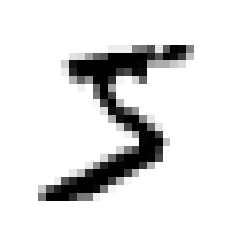

In [79]:
#이미지 확인하기

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28) #이미지가 28x28 픽셀이기 때문

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [25]:
#실제 레이블
y[0]

'5'

> 레이블은 '문자열'

In [30]:
#정수로 변환

y = y.astype(np.uint8)

In [31]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

- 훈련 세트, 테스트 세트 분리

In [32]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 2. 이진 분류기 훈련 (binary classifier)
- 예) '5 감지기' - <5>와 <5가 아닌 수> 두 개의 클래스로 구분

In [33]:
#타깃 설정

y_train_5 = (y_train == 5) #5는 True, 나머지는 False
y_test_5 = (y_test == 5)

#### SGD (Stochastic Gradient Descent 확률적 경사 하강법) Classifier 
- 분류 모델 중 하나
- 매우 큰 데이터셋을 효율적으로 처리
- 한 번에 하나씩 훈련 샘플을 독립적으로 처리
- 무작위성을 사용 (그래서 '확률적') 
    - 결과를 재현하고자 한다면 -> random_state 파라미터 사용 : 데이터 분할을 설정

In [34]:
#학습

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [35]:
#예측 (숫자 5 감지)

sgd_clf.predict([some_digit])

array([ True])

## 3. 성능 측정
- 분류기 평가 - 회귀모델보다 훨씬 어려움

### 1) 교차 검증을 사용한 정확도 측정

In [36]:
from sklearn.model_selection import cross_val_score

#폴드 3개, 정확도 측정
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

-> 정확도 : 95% 이상

In [37]:
#5 아님 클래스로 분류하는 더미 클래스

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [38]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

#### 2) Confusion Matrix (오차 행렬)
- 클래스 a의 샘플이 클래스 b로 *잘못 분류된 횟수*를 세는 것
- 예) 5 이미지를 3으로 잘못 분류한 횟수는? 오차 행렬의 5행 3열 확인

In [42]:
#예측값 만들기

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [43]:
#오차행렬 만들기

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

> 행-실제 클래스(5가 아닌 수 & 5인 수), 열-예측 클래스(5가 아니라고 예측 & 5라고 예측) <br>
      -> 왼쪽에서 오른쪽 아래로 가는 대각선만 0이 아닌 값(진짜 음성, 진짜 양성)

In [49]:
#완벽한 분류기일 경우

y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### 3) 정밀도와 재현율

In [50]:
from sklearn.metrics import precision_score, recall_score

#정밀도
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [51]:
#재현율
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [55]:
#f1_score : 정밀도와 재현율의 조화평균

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### 4) 정밀도/재현율 트레이드 오프
- 정밀도⬆️ -> 재현율⬇️  (반비례)
<br>
<br>
- 임계값⬆️
    - 정밀도⬆️ (=> 안전성⬆️)
    - 재현율⬇️

In [56]:
y_scores = sgd_clf.decision_function([some_digit]) #예측점수
y_scores

array([2164.22030239])

In [58]:
#임곗값=0
threshold=0

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [59]:
#임곗값 높여보기
threshold=8000

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

> 임곗값 높이면 -> 재현율 줄어든다. <br>
     -> 실제 숫자 5를 놓칠 가능성이 많다.

- 적절한 임곗값 구하기

In [61]:
#모든 샘플의 점수를 구해보자

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [62]:
#가능한 모든 임곗값에 대한 정밀도&재현율 구하기

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

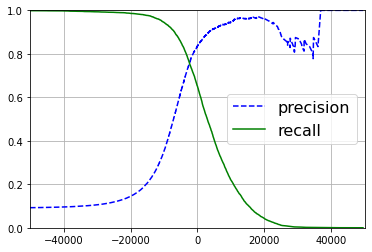

In [66]:
#시각화

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.legend(loc="center right", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [67]:
#목표 정밀도가 90%일 때

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #np.argmax - 최댓값의 첫번째 인덱스

In [68]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [70]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [71]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706